# DBTL 6 data analysis

This notebook analyzes OD340 and OD600 data from DBTL cycle 1 of a flaviolin producing P. putida.

## Inputs and outputs

#### Required file to run this notebook:
   - edd slug


#### File generated by running this notebook:
   
 
    
The files are stored in the user defined directory.

## Setup

Importing needed libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from sklearn.metrics import r2_score

import edd_utils as eddu

In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
# sys.path.append('../')
# import re
# import warnings
    
from art.core import *
# import art.plot as plot

### User parameters

In [4]:
CYCLE = 6

user_params = {
    'output_file_path': f'../data/flaviolin/DBTL{CYCLE}', # Folder for output files,
    'bounds_file': f'../data/flaviolin/Putida_media_bounds.csv',
    'study_slug': 'combinatorial-media-for-flaviolin-dbtl-6',
    'edd_server': 'edd.jbei.org',
    'username': 'tradivojevic',
    } 

In [3]:
study_slug = user_params['study_slug']
edd_server = user_params['edd_server']
username = user_params['username']

## Load the study

In [4]:
try:
  session = eddu.login(edd_server=edd_server, user=username)
except:
  print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
  print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ··············


OK! Connection to EDD successful. We will try to load data from EDD...


In [5]:
df: pd.DataFrame
    
try:
    df = eddu.export_study(session, study_slug, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    try:
        df = pd.read_csv(user_params['study_file'])
    except:
        print(f'ERROR! Alternative loading of data from disk failed!')
    else:
        print(f'OK! Alternative loading of data from disk was successful.')


  0%|          | 0/96 [00:00<?, ?it/s]

In [6]:
df.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,155578,Combinatorial media for flaviolin DBTL 6,155579,C6_WA1_C1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,155627,C6_WA1_C1-R1,NaN,Optical Density,0,NaN,0.2239,48.0
1,155578,Combinatorial media for flaviolin DBTL 6,155580,C6_WA1_C1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,155628,C6_WA1_C1-R2,NaN,Optical Density,0,NaN,0.1382,48.0
2,155578,Combinatorial media for flaviolin DBTL 6,155581,C6_WA1_C1-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,155629,C6_WA1_C1-R3,NaN,Optical Density,0,NaN,0.2228,48.0
3,155578,Combinatorial media for flaviolin DBTL 6,155582,C6_WD1_F1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,155630,C6_WD1_F1-R1,NaN,Optical Density,0,NaN,0.4953,48.0
4,155578,Combinatorial media for flaviolin DBTL 6,155583,C6_WD1_F1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,155631,C6_WD1_F1-R2,NaN,Optical Density,0,NaN,0.4894,48.0


Drop unnecessary columns:

In [7]:
df = df.loc[:,['Line Name','Line Description','Protocol','Value']]
df.head()

,Line Name,Line Description,Protocol,Value
0,C6_WA1_C1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.2239
1,C6_WA1_C1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.1382
2,C6_WA1_C1-R3,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.2228
3,C6_WD1_F1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4953
4,C6_WD1_F1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.4894


In [8]:
find_col = lambda x: x['Line Name'][5]

def find_row(row):
    line_name = row['Line Name']
    if line_name[4] == 'A':
        if int(line_name[-1]) == 1:
            return "A"
        elif int(line_name[-1]) == 2:
            return "B"
        else:
            return "C"
    else:
        if int(line_name[-1]) == 1:
            return "D"
        elif int(line_name[-1]) == 2:
            return "E"
        else:
            return "F"


In [9]:
df['Row'] =  df.apply(find_row, axis=1)
df['Column'] =  df.apply(find_col, axis=1)


In [10]:
df.head(2)

,Line Name,Line Description,Protocol,Value,Row,Column
0,C6_WA1_C1-R1,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.2239,A,1
1,C6_WA1_C1-R2,"MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.0...",OD340,0.1382,B,1


## Coefficient of variation

In [11]:
df_red = df.drop(columns=['Column'])
stats = df_red.groupby(['Protocol', 'Line Description']).mean()
stats.rename(columns={'Value': 'mean'}, inplace=True)
stats['std'] = df_red.groupby(['Protocol', 'Line Description']).std()
stats['CV[%]'] = 100* stats['std'] / stats['mean']
stats

mean  \
Protocol Line Description                                               
OD340    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.328933   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.449367   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.298367   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.419767   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.499267   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.354967   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.211100   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.405533   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.590167   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.219467   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.194967   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.371867   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.495567   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.327300   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.311633   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.542100   
OD600    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  1.263667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  1.083000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  1.106333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.884333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  1.243333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.987667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  1.151333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.790333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.667667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.750000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  1.080333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.630333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.542000   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.572667   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.930333   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.839333   

                                                                  std  \
Protocol Line Description                                               
OD340    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.027270   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.040638   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.002250   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.050896   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.012338   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.079607   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.003704   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.034875   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.01...  0.004626   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.014550   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.049164   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.02...  0.024340   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.024039   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.003843   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.041749   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.03...  0.022229   
OD600    MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.448046   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.171020   
         MOPS: 40.000000, Tricine: 4.000000, H3BO3: 0.00...  0.151988   
         MOPS: 40.000000, Tricine: 4.000000, H3BO

In [12]:
print("Mean coefficient of variation for OD340:")
np.mean(stats.loc['OD340','CV[%]'])

Mean coefficient of variation for OD340:


8.010198092935353

## Visualization

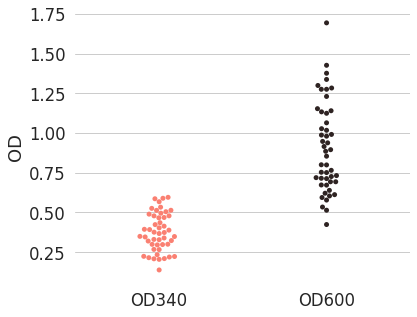

In [30]:
fig, ax = plt.subplots(figsize=(6, 5))
fontsize = 16
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.swarmplot(data=df, 
              linewidth=0,
              x='Protocol',
              y='Value',
              palette="dark:salmon_r"
              )
sns.despine(left=True, bottom=True)
ax.set(xlabel=None, ylabel="OD")

fig.savefig(
    f"{user_params['output_file_path']}/swarm_both.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

Per line:

In [14]:
line_names = []
df_340 = df[df['Protocol']=='OD340'].reset_index()
for i in range(int(len(df_340)/3)):
    line_names.append(str(df_340['Line Name'][3*i])[3:-3])
# line_names

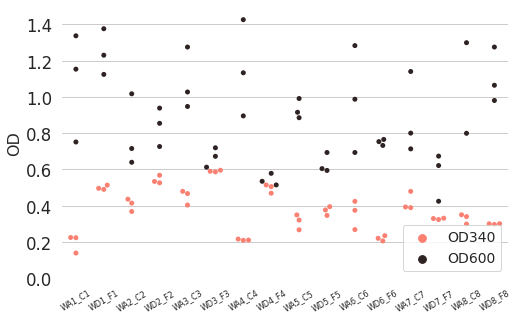

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
fontsize = 14
sns.set_style("whitegrid")
g = sns.swarmplot(data=df, 
              linewidth=0,
              x='Line Description',
              y='Value',
              hue='Protocol',
              palette="dark:salmon_r"
              )
g.set_xticklabels(line_names, fontsize=8, rotation = 30)
plt.legend(fontsize=fontsize)
sns.despine(left=True, bottom=True)
ax.set_ylabel("OD", fontsize=fontsize+2)
ax.set_xlabel(None)
plt.ylim([0, 1.5])

fig.savefig(
    f"{user_params['output_file_path']}/swarm_per_design.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

### Plot OD measurements per well

In [16]:
data_od600 = df[df['Protocol']=='OD600'].pivot('Row', 'Column')['Value']
data_od340 = df[df['Protocol']=='OD340'].pivot('Row', 'Column')['Value']

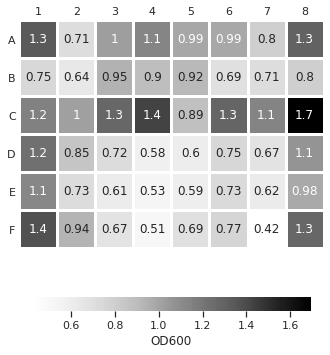

In [17]:
fig = plt.figure(figsize=(10,6))
sns.set(font_scale = 1)
ax = sns.heatmap(data=data_od600, 
                 linewidths=3, 
                 linecolor="w",
                 square= True,
                 cmap="Greys", #Greys, YlGn
                 cbar_kws={"orientation": "horizontal",
                           "shrink": 0.5,
                           'label': 'OD600'
                          },
                 annot = True,
                )
ax.set(xlabel=None, ylabel=None)
plt.yticks(rotation = 0)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
fig.savefig(
    f"{user_params['output_file_path']}/OD600.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

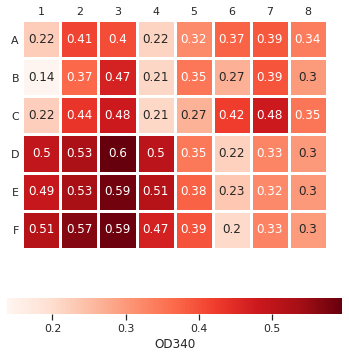

In [18]:
fig = plt.figure(figsize=(10,6))
colormap = sns.color_palette("light:salmon", as_cmap=True)
colormap = "Reds"
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 2.5})
ax = sns.heatmap(data_od340, 
                 linewidths=3, 
                 linecolor="w",
                 square= True,
                 cmap=colormap,
                 cbar_kws={"orientation": "horizontal",
                           "shrink": 0.6,
                           'label': 'OD340'
                          },
                 annot = True,
                )
ax.set(xlabel=None, ylabel=None)
plt.yticks(rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
fig.savefig(
    f"{user_params['output_file_path']}/OD340.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

### Load training data and predictions for recommendations:

In [20]:
user_params['target_designs'] = f"{user_params['output_file_path']}/target_concentrations.csv"

In [21]:
designs_pred = pd.read_csv(user_params['target_designs'], index_col=0).reset_index()
designs_pred.drop(columns='Well', inplace=True)
designs_pred['OD340'] = df[df['Protocol']=='OD340']['Value'].values
designs_pred.head()

,index,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340_pred,OD340_std,Label,OD340
0,0,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.000950,0.004621,0.000744,0.283067,0.072042,LHS,0.2239
1,1,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.000950,0.004621,0.000744,0.283067,0.072042,LHS,0.1382
2,2,0.025429,2.356942,3.646289,0.007856,6.680308,4.907831,15.155637,0.000093,0.000721,0.000950,0.004621,0.000744,0.283067,0.072042,LHS,0.2228
3,3,0.008628,0.896852,5.044414,0.017022,13.269195,2.521720,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029,0.440755,0.071896,LHS,0.4953
4,4,0.008628,0.896852,5.044414,0.017022,13.269195,2.521720,232.495019,0.000104,0.002004,0.000558,0.001644,0.000029,0.440755,0.071896,LHS,0.4894


In [24]:
user_params['train_data'] = f'../data/flaviolin/DBTL{CYCLE}/train_pred.csv'

In [25]:
train_pred = pd.read_csv(user_params['train_data'], index_col=0)
train_pred

,H3BO3,K2SO4,K2HPO4,FeSO4,NH4Cl,MgCl2,NaCl,(NH4)6Mo7O24,CoCl2,CuSO4,MnSO4,ZnSO4,OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.4422,0.380489,0.071881,0.427714,0.064774,train
1,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3405,0.380489,0.071881,0.427714,0.064774,train
2,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3397,0.380489,0.071881,0.427714,0.064774,train
3,0.003744,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.3602,0.380489,0.071881,0.427714,0.064774,train
4,0.009185,0.380499,1.156774,0.007971,11.618192,5.030266,50.607910,0.000155,0.000152,0.000029,0.000410,0.000277,0.2699,0.272370,0.071882,0.270149,0.066677,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.037489,2.431795,5.052745,0.058807,9.155386,2.372341,361.921617,0.000280,0.002575,0.000967,0.004346,0.000037,0.6091,0.607873,0.071971,0.523268,0.068902,train
236,0.037489,2.431795,5.052745,0.058807,9.155386,2.372341,361.921617,0.000280,0.002575,0.000967,0.004346,0.000037,0.6303,0.607873,0.071971,0.523268,0.068902,train
237,0.004112,0.261299,1.194531,0.010380,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109,0.2476,0.252438,0.071824,0.283199,0.066534,standard
238,0.004112,0.261299,1.194531,0.010380,8.894713,0.540169,47.852656,0.000027,0.000305,0.000096,0.000772,0.000109,0.2498,0.252438,0.071824,0.283199,0.066534,standard


In [27]:
def predictions_vs_observations(
    designs,
    train,
    errorbars_flag=False,
    xlim=None,
    ylim=None,
):
    
    plt.style.use("seaborn-white")

    fontsize = 20

    fig, ax = plt.subplots(figsize=(7, 7))
    
    obs_all = np.append(train['OD340'], designs['OD340'])
    pred_all = np.append(train['OD340_cv_pred'], designs['OD340_pred'])
    pred_std_all = np.append(train['OD340_cv_std'], designs['OD340_std'])
   
    
    # Plot Scatter Plot
    if errorbars_flag:
        plt.errorbar(
            obs_all,
            pred_all,
            yerr=1.96 * pred_std_all,
            fmt='none',
            ecolor="lightgray",
            elinewidth=1,
            alpha=0.5,
            zorder=0
        )
            
    plt.scatter(
        train['OD340'], 
        train['OD340_cv_pred'], 
        color="gray",
        label='train'
    )

    standard = train[train['Label']=='standard']
    plt.scatter(
        standard['OD340'], 
        standard['OD340_cv_pred'],
        label='standard',
        color="k"
    )
    
#     standard_des = designs[designs['Label']=='standard']
#     plt.scatter(standard_des['OD340'], standard_des['OD340_pred'], color="k")
    plt.scatter(
        designs['OD340'], 
        designs['OD340_pred'], 
        color="r",
        label='LHS'
    )
    
    r2_train = round(r2_score(train['OD340'], train['OD340_cv_pred']), 2)
    
    r2_all = round(r2_score(obs_all, pred_all), 2)

    ax.set_title(f"$R^2$={r2_train}", fontsize=fontsize)
    
    print(f"$R^2$={r2_all}")
    ax.set_xlabel("Observations", fontsize=fontsize)
    ax.set_ylabel("Cross-validation predictions", fontsize=fontsize)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    if xlim is None:
        ax.set_xlim(lims)
    else:
        ax.set_xlim(xlim)

    if ylim is None:
        ax.set_ylim(lims)
    else:
        ax.set_ylim(ylim)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    
    plt.legend(loc='best', 
               fontsize=fontsize-4)

    plt.tick_params(axis="both", which="major", labelsize=fontsize)
    plt.show()

    fig.savefig(
        user_params['output_file_path']
        + "/predictions_vs_observations.png",
        bbox_inches="tight",
        transparent=False,
        dpi=300,
    )

    plt.close(fig)

$R^2$=0.71


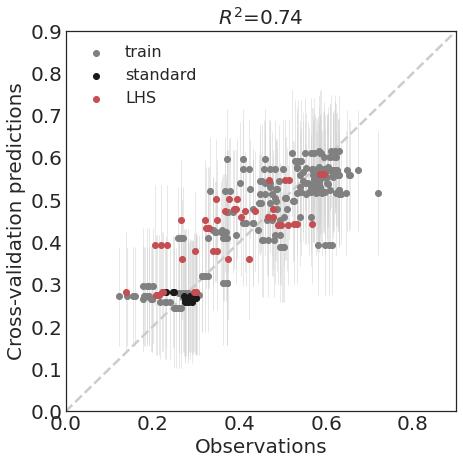

In [28]:
predictions_vs_observations(
    designs=designs_pred,
    train=train_pred,
    errorbars_flag=True,
    xlim=[0., 0.9],
    ylim=[0., 0.9],
)

## Inspect high and low producing designs

In [82]:
df_all = train_pred.drop(
    columns=['OD340_pred','OD340_std', 'OD340_cv_pred', 'OD340_cv_std', 'Label']
)
df_all = df_all.append(
    designs_pred.drop(
        columns=['OD340_pred','OD340_std', 'Label','index']
    )
)

In [84]:
df_high = df_all[df_all['OD340'] >= 0.55]
df_low = df_all[df_all['OD340'] <= 0.2]

In [86]:
len(df_high), len(df_low)

(90, 16)

In [48]:
df_bounds = pd.read_csv(user_params['bounds_file'])

In [49]:
df_bounds

,Variable,Min,Max
0,H3BO3,0.000400,0.0400
1,K2SO4,0.029000,2.9000
2,K2HPO4,0.264000,6.6000
3,FeSO4,0.001000,0.1000
4,NH4Cl,6.346667,14.2800
5,MgCl2,0.052000,5.2000
6,NaCl,5.000000,500.0000
7,(NH4)6Mo7O24,0.000003,0.0003
8,CoCl2,0.000030,0.0030
9,CuSO4,0.000010,0.0010


In [87]:
def designs_pairwise(df_high, df_low, bounds):

    components = df_high.columns[:-1]
    dim = len(components)
#     print(f'dim={dim}')

    plt.style.use('seaborn-whitegrid')

    fig = plt.figure(figsize=(35, 35))
    fig.patch.set_facecolor("white")

    X_high = df_high[components].values
    X_low = df_low[components].values

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            
            ax.scatter(
                X_high[:, var1],
                X_high[:, var2],
                c="g",
                marker="+",
                s=150*df_high['OD340'],
                lw=1,
                label="high",
            )
            ax.scatter(
                X_low[:, var1],
                X_low[:, var2],
                c="r",
                marker="+",
                s=150*df_low['OD340'],
                lw=1,
                label="low",
            )
            xlims = np.asarray([
                bounds[bounds['Variable']==components[var1]]['Min'],
                bounds[bounds['Variable']==components[var1]]['Max']
            ])
            ylims = np.asarray([
                bounds[bounds['Variable']==components[var2]]['Min'],
                bounds[bounds['Variable']==components[var2]]['Max']
            ])
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)
                        
            if var2 == (dim - 1):
                ax.set_xlabel(components[var1])
            if var1 == 0:
                ax.set_ylabel(components[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

    fig.savefig(
        f'{user_params["output_file_path"]}/designs_pairwise_high.png',
        bbox_inches="tight",
        transparent=False, 
        dpi=300
    )

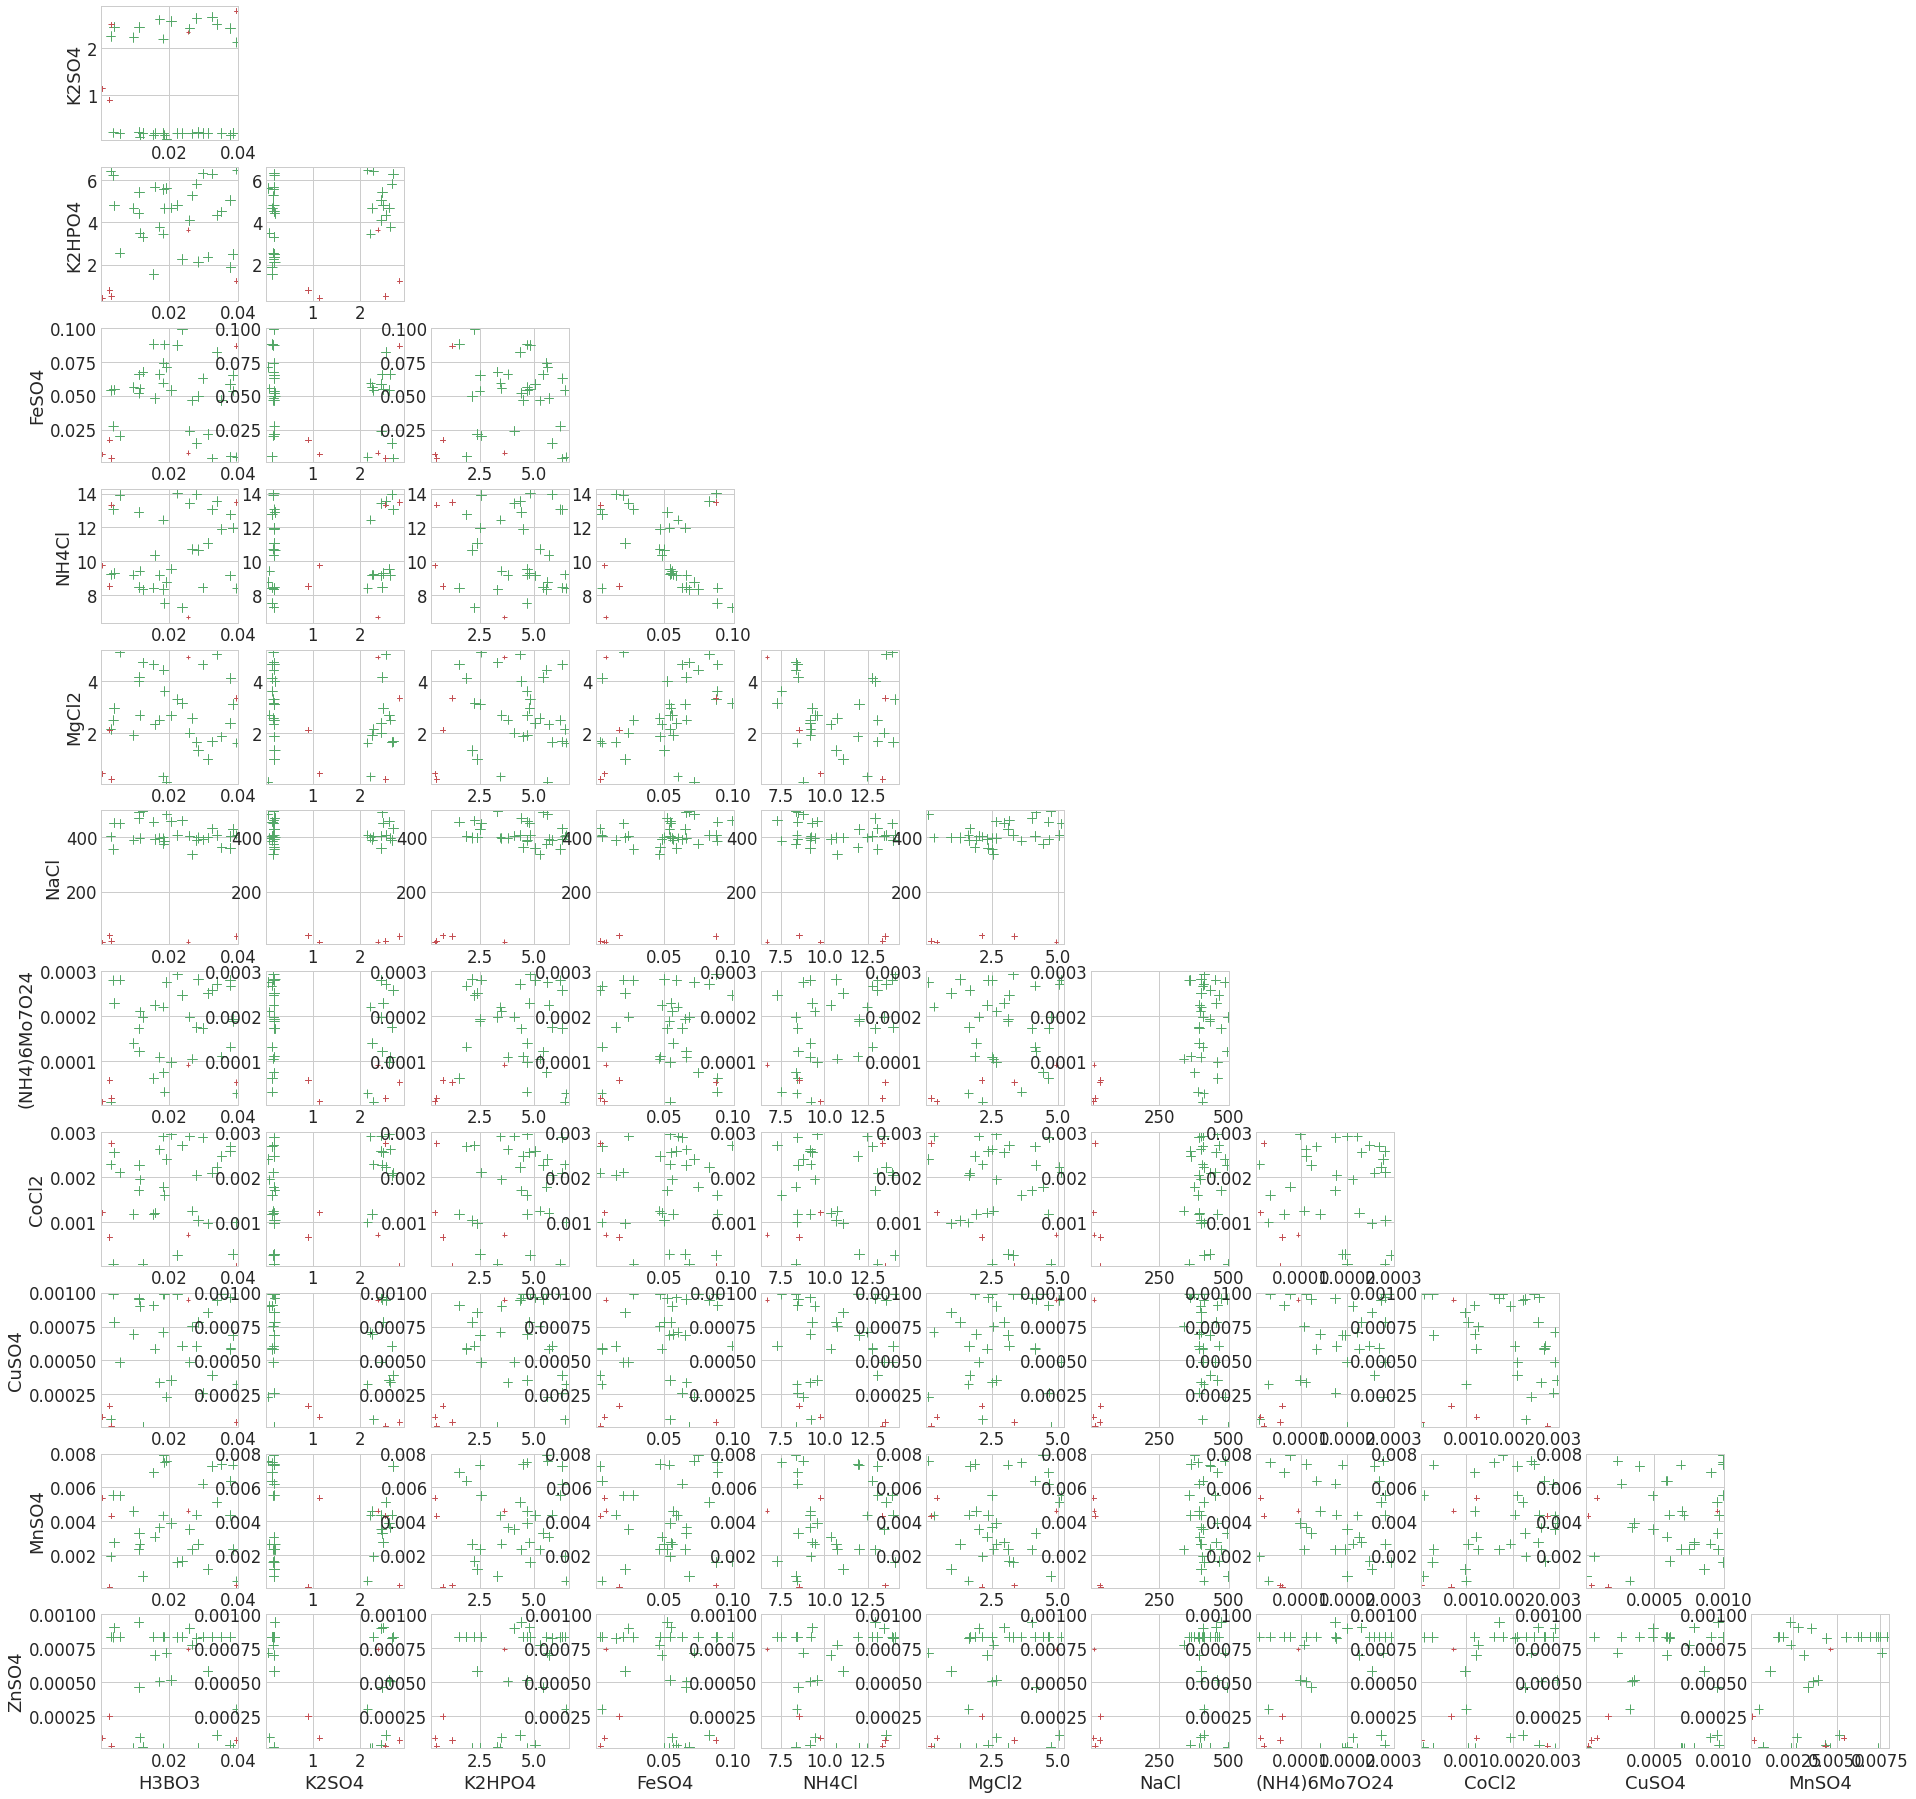

In [88]:
designs_pairwise(df_high, df_low, df_bounds)

In [11]:
warnings.filterwarnings("ignore")
with open(os.path.join(user_params['output_file_path'], 'art.pkl'), 'rb') as output:
    art = pickle.load(output)

ModuleNotFoundError: No module named 'sklearn.neighbors._dist_metrics'

In [9]:
import sklearn.neighbors.dist_metrics
sys.modules['sklearn.neighbors._dist_metrics'] = sklearn.neighbors.dist_metrics

ModuleNotFoundError: No module named 'sklearn.neighbors.dist_metrics'

In [10]:
import sklearn.neighbors